In [1]:
import pandas as pd
import numpy as np
import csv
import os
from os import path
import weblogo
import seqlogo
%matplotlib inline


In [3]:
filteredGeneList = pd.read_csv('../../../Database/mouse database/filteredGenesDetails_mouse_160617.txt',sep='\t')
acc2gene={}
for idx,row in filteredGeneList.iterrows():
    acc2gene[row['AccNum']] = row['GeneName']

In [4]:
def get_fa(filename,onlyKeys = 'All'):
    keyD = dict()
    if onlyKeys!='All':
        for k in onlyKeys: keyD[k] = None
        
    def addEntry(current,d):
        entry = current.split('\n')
        if entry[0]!='' and (onlyKeys=='All' or keyD.has_key(entry[0])):
            d[entry[0]] = ''.join(entry[1:])

    d = dict()
    bf = open(filename)
    current = ['\n']
    for line in bf:
        if line[0]=='>':
            addEntry(''.join(current),d)
            if len(line)>1: current = [line[1:]]
            else: current = ['\n']
        else: current.append(line)
    addEntry(''.join(current),d)
    bf.close()
    return d

In [6]:
splicedGenes = get_fa('../../../Database/mouse database/splicedGenes_160617.txt')
## truncate the keys to only accNum
ks = list(splicedGenes.keys())
for key in ks:
    splicedGenes[key.split('_chr')[0]] = splicedGenes[key]
    splicedGenes.pop(key)
splicedORFs = get_fa('../../../Database/mouse database/splicedORFs_160617.txt')

In [7]:
fpUTR={}
tpUTR = {}
ORFs = {}
for idx,row in filteredGeneList.iterrows():
    accNum = row['AccNum']
    fpLen = row['fpUTR_length']
    tpLen = row['tpUTR_length']
    fpUTR[accNum] = splicedGenes[accNum][0:fpLen]
    tpUTR[accNum] = splicedGenes[accNum][-tpLen:]
    ORFs[accNum] = splicedORFs[accNum]

In [25]:
class Sequences:
    nt2coord = {'A':0,'C':1,'G':2,'T':3}
    
    def seqLikelihood(self,SEQ):
        nt2coord = {'A':0,'C':1,'G':2,'T':3}
        prob = 1
        assert (len(SEQ)==19)
        for i in range(8):
            pos_prob = self.ppm[i,nt2coord[SEQ[i]]]
            prob*= pos_prob
        for i in range(11,19):
            pos_prob = self.ppm[i,nt2coord[SEQ[i]]]
            prob*= pos_prob
        return np.log(prob)
    
    @staticmethod
    def genes2seq(genes):
        seqs = []
        for gene in genes:
            if gene in fpUTR:
                fp=fpUTR[gene]
                if len(fp)<8:
                    #print('No fpUTR encountered: ',acc2gene[gene])
                    continue
                seq = fp[-8:]+ORFs[gene][:11]
                seqs.append(seq)
        #print('# of valid seqs: ',len(seqs))
        return seqs
    
    def __init__(self,seqs):
        self.seqs=seqs
        self.pfm, self.ppm = self.comp_count()
        self.flat = self.ppm2flat()
    
    def addseqs(self,seqs):
        self.seqs.extend(seqs)
        self.pfm,self.ppm = self.comp_count()
        self.flat = self.ppm2flat()
    
    def __len__(self):
        return len(self.seqs)
    
    def comp_count(self,seqLen=19):
        
        raw_count = np.zeros((seqLen,4))
        lines_tr=[''.join(s) for s in zip(*(self.seqs))]
        #print('#lines = ',len(seqs))
        for i in range(seqLen):
            raw_count[i][0] = lines_tr[i].count('A')
            raw_count[i][1] = lines_tr[i].count('C')
            raw_count[i][2] = lines_tr[i].count('G')
            raw_count[i][3] = lines_tr[i].count('T')
        ppm = self.pfm2ppm(raw_count)
        return raw_count, ppm
    
    ## Note: ppm here is the same as the so-called pwm in R,
    ## True meaning of 'pwm' vary from literatures
    def pfm2ppm(self,pfm):
        sum_of_rows = pfm.sum(axis=1)
        return pfm / sum_of_rows[:, np.newaxis]
    
    def plotlogo(self):
        pfm_pd=pd.DataFrame(self.pfm)
        ppm_pd=seqlogo.pfm2ppm(pfm_pd)
        ppm = seqlogo.Ppm(ppm_pd)
        plt=seqlogo.seqlogo(ppm, ic_scale = True, format = 'png', size = 'large')#,filename=datset+'.png')
        #seqlogo.seqlogo(ppm, ic_scale = True, format = 'svg', size = 'medium')#,filename=datset+'.svg')
        return plt
    
    def ppm2flat(self):
        return self.ppm[list(range(0,8))+list(range(11,19)), 0:4].reshape(-1)
    
    
    def bootstrap(self,num):    # with replacement
        sample_seqs = np.random.choice(self.seqs, size=num)
        return Sequences(sample_seqs.tolist())
    
    def sample(self,num): # without replacement
        sample_seqs = np.random.choice(self.seqs, size=num,replace=False)
        return Sequences(sample_seqs.tolist())

    def __gt__(self, seq2):
        return True

In [58]:
from scipy.stats import chisquare
import seaborn as sns
class TestSeq:
    
    def __init__(self,target,test,resample=10000,num=None):
        self.resample=resample
        self.target=target
        self.test=test
        self.ps, self.seqs=self.createTest(target,test,resample,num)
        
    @classmethod
    def createTest(cls,target,test,resample=10000,num=None):
        if num==None:
            num=len(target)
        ps = []
        seqs=[]
        for i in range(0,resample):
            seq = test.sample(num)
            seq.flat = seq.flat+0.01
            target = target.sample(num)
            target.flat = target.flat + 0.01
            ## dof = (4-1)*(8+8) = 48, number of freqs = 64
            ## dof = k - 1 - ddof
            ## ddof = 64 - 1 - 48 = 15
            _, p = chisquare(seq.flat*len(target),f_exp=target.flat*len(target),ddof=14)
            ps.append(p)
            seqs.append(seq)
        both = sorted(zip(ps,seqs))
        ps,seqs = [y for y,x in both],[x for y,x in both]
        return ps, seqs

    def dist(self):
        return sns.distplot(self.ps)
    def logdist(self):
        return sns.distplot(np.log2(self.ps))

In [59]:
def pfm2ppm_df(pfm):
    pfm_pd=pd.DataFrame(pfm)
    ppm_pd=seqlogo.pfm2ppm(pfm_pd)
    return seqlogo.Ppm(ppm_pd).T

In [42]:
batch = 'ER_L24_t1'
deseq = pd.read_csv('../../Deseq2 Analysis/shift15/coding/csv_raw/'+batch+'.csv')
deseq = deseq.sort_values(by=['log2FoldChange'])
print(len(deseq))
deseq.head(2)

7990


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
4630,NM_001323903,469.064409,-0.856224,0.115062,-7.441441,9.959267e-14,7.957454e-10
3442,NM_002520,354.824004,-0.839931,0.212296,-3.956422,7.608086e-05,3.775690e-03


In [43]:
background = deseq['Unnamed: 0']
deseq_filtered = deseq.loc[deseq['padj']<0.05]
up_num = sum(deseq_filtered['log2FoldChange'] > 1)
target = deseq_filtered.tail(up_num)['Unnamed: 0']   # i.e. Interest group, upper right on volcano plot
down_num=sum(deseq_filtered['log2FoldChange']<-1)
print(up_num,down_num)


40 0


In [44]:
#!mkdir deseq_test/pwms/$batch
target_seq = Sequences(Sequences.genes2seq(target))
bg_seq = Sequences(Sequences.genes2seq(background))
down_num=sum(deseq_filtered['log2FoldChange']<-1)
dep_seq=Sequences(Sequences.genes2seq(deseq_filtered.head(up_num)['Unnamed: 0']))

ppm_out = pfm2ppm_df(target_seq.pfm)
#ppm_out.to_csv("deseq_test/pwms/"+batch+"/"+batch+"_enriched"+".csv")
ppm_out = pfm2ppm_df(dep_seq.pfm)
#ppm_out.to_csv("deseq_test/pwms/"+batch+"/"+batch+"_depleted"+".csv")
ppm_out = pfm2ppm_df(bg_seq.pfm)
#ppm_out.to_csv("deseq_test/pwms/"+batch+"/"+"bg"+".csv")

In [39]:
np.random.seed(42)
test = TestSeq(target_seq,bg_seq,10000)
test2 = TestSeq(bg_seq,bg_seq,10000,len(target_seq))

In [40]:
!mkdir deseq_wo_replace
!mkdir deseq_wo_replace/$batch
t0 = TestSeq(target_seq,target_seq,10000)


mkdir: deseq_wo_replace: File exists
mkdir: deseq_wo_replace/ER_S15_t1: File exists


/Users/Yue/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


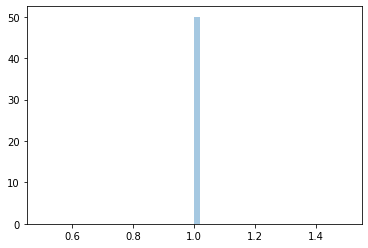

In [41]:
ax=t0.dist()
ax.get_figure().savefig("deseq_wo_replace/"+batch+"/"+batch+"_self_hist.png")

/Users/Yue/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


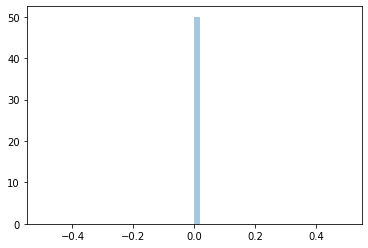

In [42]:
ax=t0.logdist()
ax.get_figure().savefig("deseq_wo_replace/"+batch+"/"+batch+"_self_hist_log.png")

<class 'matplotlib.axes._subplots.AxesSubplot'>


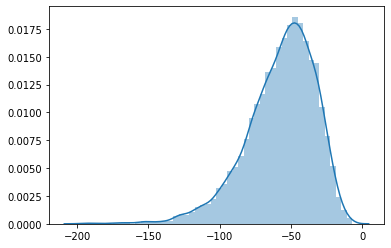

In [20]:
ax=test.logdist()
print(type(ax))
#ax.get_figure().savefig("deseq_wo_replace/"+batch+"/"+batch+"_test_hist.png")

In [64]:
from scipy import stats
x = ax.lines[0].get_xdata() # Get the x data of the distribution
y = ax.lines[0].get_ydata() # Get the y data of the distribution
maxid = np.argmax(y) # The id of the peak (maximum of y data)
mode = x[maxid]
logp = np.log(test.ps)
median = np.median(logp)
std=np.std(logp)
print(mode,median,std)

-47.61413889807437 -37.13931387613066 16.898140954499453


In [65]:
left = np.searchsorted(logp,mode-std)
mid = np.searchsorted(logp,mode)
right = np.searchsorted(logp,mode+std)
print(left,mid,right)

809 2763 6669


In [66]:
!pwd
def disp_save_img(idx,pos):
    num = 50
    for i in range(num):
        seq = test.seqs[i-num//2+idx]
        if i == 0:
            com_seq = seq
        else:
            com_seq.addseqs(seq.seqs)
#        img=seq.plotlogo()
        #display(img)
#        with open("deseq_wo_replace/"+batch+"/"+pos+str(i)+".png", "wb") as png:
#            png.write(img.data)
    img=com_seq.plotlogo()
    #display(img)
#    with open("deseq_wo_replace/"+batch+"/"+pos+'_comb'+str(num)+".png", "wb") as png:
#        png.write(img.data)
    ppm_out = pfm2ppm_df(com_seq.pfm)
    ppm_out.to_csv("deseq_test/pwms/"+batch+"/"+batch+'_'+pos+'_comb'+str(num)+".csv")

disp_save_img(mid,'median')
disp_save_img(left,'leftstd')
disp_save_img(right,'rightstd')

/Users/Yue/Documents/HGLab_new/RBC/MOTIF/SeqLogo


In [333]:
img=target_seq.plotlogo()
with open("deseq_wo_replace/"+batch+"/enriched"+".png", "wb") as png:
    png.write(img.data)
img=bg_seq.plotlogo()
with open("deseq_wo_replace/"+batch+"/background"+".png", "wb") as png:
    png.write(img.data)
img=dep_seq.plotlogo()
with open("deseq_wo_replace/"+batch+"/depleted"+".png", "wb") as png:
    png.write(img.data)

In [11]:
filteredGeneList = pd.read_csv('../../Database/filteredGenesDetails_human_240118.txt',sep='\t')
acc2gene={}
gene2acc={}
for idx,row in filteredGeneList.iterrows():
    acc2gene[row['AccNum']] = row['GeneName']
    gene2acc[row['GeneName']] = row['AccNum']
filteredGeneList.head(2)

,GeneName,AccNum,Chrom,mRNALength,ORFLength,fpUTR_length,tpUTR_length,sumIntronLengths
0,UBE2Q1,NM_017582,chr1,3223,1269,91,1863,6847
1,DUOXA1,NM_001276267,chr15,3032,897,395,1740,9479


In [12]:
target_seq = Sequences(Sequences.genes2seq(target))
bg_seq = Sequences(Sequences.genes2seq(background))

In [13]:
probs = []
genes = []
prob_genes = []
for gene in target:
    seq = Sequences.genes2seq([gene])
    if len(seq)!=1: continue
    prob=target_seq.seqLikelihood(seq[0])
    prob_genes.append((prob,acc2gene[gene],gene))

In [31]:
prob_genes.sort(reverse=True)
prob_genes[:5]

[(-15.691570664157982, 'ALKBH4', 'NM_017621'),
 (-15.933307524572562, 'FRAT2', 'NM_012083'),
 (-16.138101937218575, 'MZT2B', 'NM_001330282'),
 (-16.66014887963749, 'TSPO', 'NM_001256530'),
 (-16.898874447357187, 'MMP14', 'NM_004995')]

In [32]:
Sequences.genes2seq(['NM_017621','NM_012083','NM_001330282','NM_001256530','NM_004995'])

['ACGGCGCGATGGCGGCGGC',
 'GGGGGGCCATGCCGTGCCG',
 'CCGCGGGGATGGCGGCGCA',
 'CAGCAGCCATGGCCCCGCC',
 'CTCGGACCATGTCTCCCGC']

In [14]:
prob_genes_bg = []
for gene in background:
    seq = Sequences.genes2seq([gene])
    if len(seq)!=1: continue
    prob=target_seq.seqLikelihood(seq[0])
    prob_genes_bg.append((prob,acc2gene[gene],gene))

In [17]:
prob_genes_bg.sort(reverse=False)
prob_genes_bg[:5]

[(-34.93667633262415, 'DMXL1', 'NM_001290322'),
 (-33.97571915376443, 'SCRN3', 'NM_024583'),
 (-33.84603221360522, 'FASTKD1', 'NM_001322046'),
 (-33.84603221360522, 'RPRD1A', 'NM_001303411'),
 (-33.68368476657378, 'SDCBP', 'NM_001348341')]

In [35]:
Sequences.genes2seq(['NM_001290322','NM_024583','NM_001322046','NM_001303411','NM_001348341'])

['TTCATTTAATGAAATTTTC',
 'TAAAAAAAATGGAACCTTT',
 'TGATATAAATGAAAAAAAC',
 'TGCAACAAATGAGAAATTC',
 'AAAATTAAATGATAAAGCT']

In [36]:
prob_genes_bg[-5:]

[(-14.691182954282251, 'AFG3L2', 'NM_006796'),
 (-14.66846592799802, 'LAMP1', 'NM_005561'),
 (-14.663012077315555, 'AGFG1', 'NM_001135187'),
 (-14.550682892341635, 'PPP1R14B', 'NM_138689'),
 (-14.542486125137456, 'MYO1D', 'NM_015194')]

In [37]:
Sequences.genes2seq(['NM_006796','NM_005561','NM_001135187','NM_138689','NM_015194'])

['CGGCGGCCATGGCGCACCG',
 'CTCGCGCCATGGCGGCCCC',
 'CCGCGGCCATGGCGGCCAG',
 'CGGCCGCCATGGCGGACAG',
 'CTGGCGCCATGGCGGAGCA']

In [87]:
Sequences.genes2seq(['NM_017621'])

# of valid seqs:  1


['ACGGCGCGATGGCGGCGGC']

In [88]:
Sequences.genes2seq(['NM_001290322'])

# of valid seqs:  1


['TTCATTTAATGAAATTTTC']

In [46]:
len(target_seq)

75

In [61]:
batch = 'rpl22'
target = pd.read_csv(batch+'.txt',sep='\t',header=None)[1].dropna()
background = pd.read_csv('bg.txt',sep='\t',header=None)[1].dropna()

In [62]:
target_seq = Sequences(Sequences.genes2seq(target))
bg_seq = Sequences(Sequences.genes2seq(background))

In [63]:
img=target_seq.plotlogo()
with open(batch+"_enriched"+".png", "wb") as png:
    png.write(img.data)
img=bg_seq.plotlogo()
with open("background"+".png", "wb") as png:
    png.write(img.data)


D:\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log2


OverflowError: cannot convert float infinity to integer

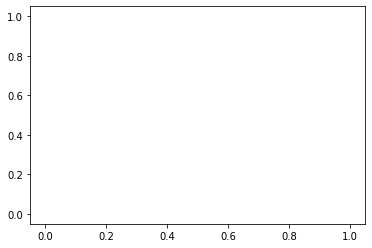

In [64]:
np.random.seed(42)
test = TestSeq(target_seq,bg_seq,10000)
ax=test.logdist()
ax.get_figure().savefig(batch+"_test_hist.png")

In [ ]:
from scipy import stats
x = ax.lines[0].get_xdata() # Get the x data of the distribution
y = ax.lines[0].get_ydata() # Get the y data of the distribution
maxid = np.argmax(y) # The id of the peak (maximum of y data)
mode = x[maxid]
logp = np.log(test.ps)
median = np.median(logp)
std=np.std(logp)
print(mode,median,std)

In [57]:
test.ps

[0.0,
 0.0,
 0.0,
 0.0,
 4.3624544252905145e-278,
 2.7592339062413294e-277,
 4.915586932014141e-277,
 5.453864061328422e-274,
 1.432350560348456e-272,
 2.5610519460651166e-272,
 3.504573690347171e-271,
 2.872841789984277e-270,
 1.0958323351128767e-268,
 6.039652154783967e-237,
 8.695876053102216e-235,
 1.289084623461567e-230,
 2.52048137893767e-229,
 1.79958814572947e-228,
 1.9181241980042932e-228,
 1.936936538999015e-228,
 1.9393662132684778e-228,
 2.2377549473679025e-228,
 2.7257177409783603e-228,
 8.975632678478113e-228,
 1.238350849360088e-227,
 1.4516285978003871e-227,
 3.391777217442456e-227,
 5.095594970588968e-227,
 9.036983602272943e-227,
 1.5239616778820297e-226,
 1.674976541976617e-225,
 1.1172460687211913e-224,
 1.1934311098729453e-224,
 5.299895201884472e-224,
 1.9532631601669035e-223,
 8.543619938007221e-223,
 9.173729065144163e-223,
 2.922475023584421e-222,
 1.3972631299505042e-221,
 5.871653252171025e-221,
 1.1794577862041294e-220,
 1.877741715744052e-220,
 2.4306684494

33 1
189 15
110 8
40 0


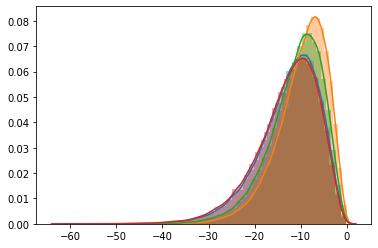

In [20]:
for batch in ['ER_S15_t2','ER_S15_t1','ER_S15_t0','ER_L24_t1']:
    #batch = 'ER_S15_t2'
    deseq = pd.read_csv('../../Deseq2 Analysis/shift15/coding/csv_raw/'+batch+'.csv')
    deseq = deseq.sort_values(by=['log2FoldChange'])
    background = deseq['Unnamed: 0']
    deseq_filtered = deseq.loc[deseq['padj']<0.05]
    up_num = sum(deseq_filtered['log2FoldChange'] > 1)
    target = deseq_filtered.tail(up_num)['Unnamed: 0']   # i.e. Interest group, upper right on volcano plot
    down_num=sum(deseq_filtered['log2FoldChange']<-1)
    print(up_num,down_num)
    target_seq = Sequences(Sequences.genes2seq(target))
    bg_seq = Sequences(Sequences.genes2seq(background))
    down_num=sum(deseq_filtered['log2FoldChange']<-1)
    dep_seq=Sequences(Sequences.genes2seq(deseq_filtered.head(up_num)['Unnamed: 0']))
    np.random.seed(42)
    # test = TestSeq(target_seq,bg_seq,100000)
    # ax=test.logdist()
    # with open('deseq_wo_replace/ps/'+batch+"_enrich_vs_bg_test_ps.txt", 'w') as f:
    #     for item in test.ps:
    #         f.write("%s\n" % item)
    test2 = TestSeq(bg_seq,bg_seq,100000,up_num)
    ax = test2.logdist()
    with open('deseq_wo_replace/ps/'+batch+"_bg_vs_bg_test_ps (enrichnum).txt", 'w') as f:
        for item in test2.ps:
            f.write("%s\n" % item)

In [52]:
from pprint import pprint
>>> pprint (TestSeq(bg_seq,bg_seq,1,up_num).ps[0])
seq = bg_seq.sample(up_num)
            ## dof = (4-1)*(8+8) = 48, number of freqs = 64
            ## dof = k - 1 - ddof
            ## ddof = 64 - 1 - 48 = 15
_, p = chisquare(seq.flat*len(target),f_exp=target.flat*len(target),ddof=14)
            ps.append(p)
            seqs.append(seq)

0.0


In [18]:
from pprint import pprint
>>> pprint (TestSeq(bg_seq,bg_seq,1,up_num).ps[0])

0.008281543319458098


In [ ]:
target_s